# Case 1 - HWP

HWP Angle: 0
o_avg Mueller Matrix: [[ 0.48863394 -0.48032382  0.08931124  0.02035446]
 [ 0.48863394 -0.48032382  0.08931124  0.02035446]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
e_avg Mueller Matrix: [[ 0.48843379  0.48350613 -0.07008181 -0.01450504]
 [-0.48843379 -0.48350613  0.07008181  0.01450504]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
o_stokes_avg: [[0.00831012]
 [0.00831012]
 [0.        ]
 [0.        ]]
e_stokes_avg: [[ 0.97193991]
 [-0.97193991]
 [ 0.        ]
 [ 0.        ]]
Normalized Single Diff Avg: -0.9830448964170571
HWP Angle: 10
o_avg Mueller Matrix: [[ 0.48870589 -0.42639712 -0.22648944 -0.07808819]
 [ 0.48870589 -0.42639712 -0.22648944 -0.07808819]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
e_avg Mueller Matrix: [[ 0.48833513  0.41644994  0.24194002  0.08300155]
 [-0.48833513 -0.41644994

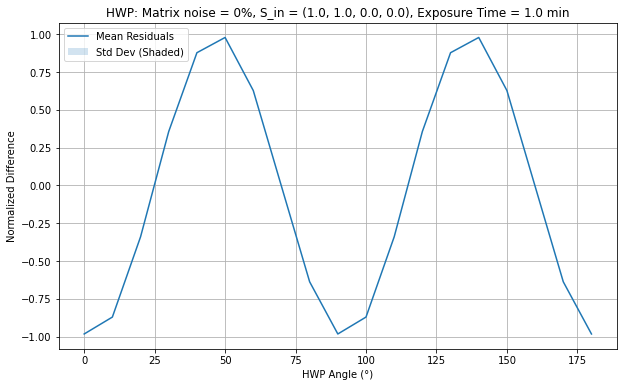

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../python/')
import angles
import instrument_mm

# For collecting single differences
normalized_diffs_list = []

# Define observer parameters
observer_latitude = 20.0  # Latitude of Mauna Kea in degrees
observer_longitude = -155.5  # Longitude of Mauna Kea in degrees

# Define target parameters
targets = [
    {"name": "Hamal", "ra": 31.791, "dec": 23.462},  # Hamal (Alpha Arietis)
    # {"name": "Mirfak", "ra": 51.079, "dec": 49.861},  # Mirfak (Alpha Persei)
    # {"name": "Polaris", "ra": 37.954, "dec": 89.264},  # Polaris (Alpha Ursae Minoris)
]

# Observation date and time
observation_date = "2460614.91667"  # JD for 10/31/2024
observation_time = "10:00:00"   # UT time to get peak at midnight HST
matrix_noise_type = "additive"

# Fixed integration time and sub-integration time
t_int = 1 * 60  # 1 minute in seconds
sub_tint = 1  # 0.5 seconds
num_samples = 100

# Injected polarization
Q_injected = 1.0  # Injected Stokes Q
U_injected = 0.0  # Injected Stokes U
V_injected = 0.0
noise_percentage = 1  # Intensity noise
include_V = False

# NOTE: For HWP
delta_HWP = 0.5
# HWP_angs = np.array([0, 22.5, 45, 67.5])
filename_tag = "HWP_regular_modulation"
HWP_angs = range(0, 181, 10)

# NOTE: For QWP
# delta_HWP = 0.25
# HWP_angs = [-42.54276834, 13.22282288, 44.37773779, 76.67675033]
# filename_tag = "QWP_Katsu_Measurement_Matrix_Inverse_Cond_Num_Minimization"
# HWP_angs = np.array([-45, 45, -135, 135])
# filename_tag = "QWP_measuring_V_only"

# NOTE: For 0.3661 waveplate
# delta_HWP = 0.3661
# HWP_angs = np.array([-51.69, 51.69, -15.12, 15.12])
# First Minimization Set
# HWP_angs = [4.27995253, 57.56520381, 31.06321892, -37.47077834]
# HWP_angs = [26.04379451, -9.86586612, 60.51771256, -41.96646101]
# filename_tag = "Third_wp"


# Matrix noise range
matrix_noise_range = np.arange(0, 1)  # From 1% to 5%
num_trials = 50  # Number of trials per noise level

# Loop over each target
for target in targets:
    mean_residuals = []
    std_residuals = []

    # Loop over matrix noise levels
    for matrix_noise in matrix_noise_range:
        residuals = []

        # Perform multiple trials for each noise level
        for trial in range(num_trials):
            normalized_diff = instrument_mm.calculate_input_Q_U_observing_sequence_matrix_inversion(
                ra=target["ra"], 
                dec=target["dec"], 
                observer_latitude=observer_latitude, 
                observer_longitude=observer_longitude, 
                jd_str=observation_date, 
                ut_start=observation_time, 
                t_int=t_int, 
                Q=Q_injected, 
                U=U_injected, 
                V=V_injected,
                delta_HWP=delta_HWP,
                HWP_angs = HWP_angs,
                noise_percentage=noise_percentage,
                include_V=include_V,
                sub_tint=sub_tint,  # Sub-integration time in seconds
                TMT_matrix_noise=matrix_noise,
                NFIRAOS_matrix_noise=matrix_noise,
                MODHIS_matrix_noise=matrix_noise,
                observable="intensities",  # Or "single_difference" if needed
                sampled_steps = num_samples,
                matrix_noise_type = matrix_noise_type,
                return_type = "normalized_diff"
            )
            normalized_diffs_list.append(normalized_diff)

        # Compute mean and standard deviation of residuals for this noise level
        normalized_diffs_list = np.array(normalized_diffs_list)
        normalized_diffs_medians = np.median(normalized_diffs_list, axis = 0)
        normalized_diffs_stds = np.std(normalized_diffs_list, axis = 0)

        # Save the residuals as a .npy file
        filename = f"{target['name']}_QWP_Q_{Q_injected}_U_{U_injected}_V_{V_injected}_residuals_matrix_noise_{matrix_noise}_tint_{t_int}_sub_tint_{sub_tint}_readout_noise_{noise_percentage}_{matrix_noise_type}_{filename_tag}.npy"
        np.save(filename, np.array(normalized_diffs_list))
        print(f"Saved residuals to {filename}")

    # Plot the NOrmalized difference 
    plt.figure(figsize=(10, 6))

    plt.plot(HWP_angs, normalized_diffs_medians, label=f"Mean Residuals")
    plt.fill_between(HWP_angs, normalized_diffs_medians - normalized_diffs_stds, normalized_diffs_medians + normalized_diffs_stds, alpha=0.2, label="Std Dev (Shaded)")
    plt.xlabel("HWP Angle (°)")
    plt.ylabel("Normalized Difference")
    plt.title(
        f"HWP: Matrix noise = {matrix_noise}%, S_in = (1.0, {Q_injected}, {U_injected}, {V_injected}), Exposure Time = {t_int / 60:.1f} min"
    )
    plt.grid(True)
    plt.legend()
    plt.show()


# CASE 2: QWP sampling all Stokes parameters

HWP Angle: 0
o_avg Mueller Matrix: [[ 0.4896287   0.01178742  0.17853436 -0.45642076]
 [ 0.4896287   0.01178742  0.17853436 -0.45642076]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
e_avg Mueller Matrix: [[ 0.48744102 -0.00762089 -0.15912649  0.46131663]
 [-0.48744102  0.00762089  0.15912649 -0.46131663]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
o_stokes_avg: [[0.50141612]
 [0.50141612]
 [0.        ]
 [0.        ]]
e_stokes_avg: [[ 0.47982013]
 [-0.47982013]
 [ 0.        ]
 [ 0.        ]]
Normalized Single Diff Avg: 0.022008966286432303
HWP Angle: 10
o_avg Mueller Matrix: [[ 0.48966457  0.03869453  0.0207057  -0.4883045 ]
 [ 0.48966457  0.03869453  0.0207057  -0.4883045 ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
e_avg Mueller Matrix: [[ 0.4873918  -0.04120723 -0.00117647  0.48625432]
 [-0.4873918   0.0412072

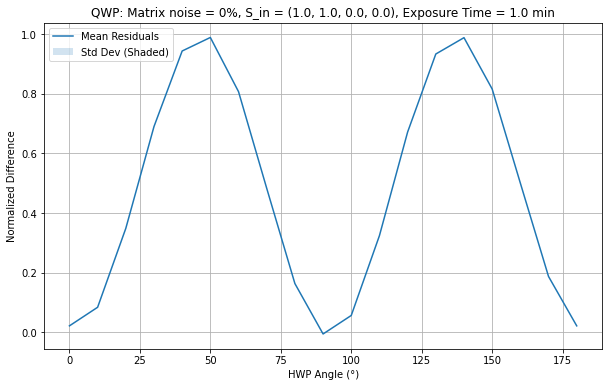

In [5]:
# For collecting single differences
normalized_diffs_list = []

# NOTE: For QWP
delta_HWP = 0.25
filename_tag = "QWP"

# Loop over each target
for target in targets:
    mean_residuals = []
    std_residuals = []

    # Loop over matrix noise levels
    for matrix_noise in matrix_noise_range:
        residuals = []

        # Perform multiple trials for each noise level
        for trial in range(num_trials):
            normalized_diff = instrument_mm.calculate_input_Q_U_observing_sequence_matrix_inversion(
                ra=target["ra"], 
                dec=target["dec"], 
                observer_latitude=observer_latitude, 
                observer_longitude=observer_longitude, 
                jd_str=observation_date, 
                ut_start=observation_time, 
                t_int=t_int, 
                Q=Q_injected, 
                U=U_injected, 
                V=V_injected,
                delta_HWP=delta_HWP,
                HWP_angs = HWP_angs,
                noise_percentage=noise_percentage,
                include_V=include_V,
                sub_tint=sub_tint,  # Sub-integration time in seconds
                TMT_matrix_noise=matrix_noise,
                NFIRAOS_matrix_noise=matrix_noise,
                MODHIS_matrix_noise=matrix_noise,
                observable="intensities",  # Or "single_difference" if needed
                sampled_steps = num_samples,
                matrix_noise_type = matrix_noise_type,
                return_type = "normalized_diff"
            )
            normalized_diffs_list.append(normalized_diff)

        # Compute mean and standard deviation of residuals for this noise level
        normalized_diffs_list = np.array(normalized_diffs_list)
        normalized_diffs_medians = np.median(normalized_diffs_list, axis = 0)
        normalized_diffs_stds = np.std(normalized_diffs_list, axis = 0)

        # Save the residuals as a .npy file
        filename = f"{target['name']}_QWP_Q_{Q_injected}_U_{U_injected}_V_{V_injected}_residuals_matrix_noise_{matrix_noise}_tint_{t_int}_sub_tint_{sub_tint}_readout_noise_{noise_percentage}_{matrix_noise_type}_{filename_tag}.npy"
        np.save(filename, np.array(normalized_diffs_list))
        print(f"Saved residuals to {filename}")

    # Plot the NOrmalized difference 
    plt.figure(figsize=(10, 6))

    plt.plot(HWP_angs, normalized_diffs_medians, label=f"Mean Residuals")
    plt.fill_between(HWP_angs, normalized_diffs_medians - normalized_diffs_stds, normalized_diffs_medians + normalized_diffs_stds, alpha=0.2, label="Std Dev (Shaded)")
    plt.xlabel("HWP Angle (°)")
    plt.ylabel("Normalized Difference")
    plt.title(
        f"QWP: Matrix noise = {matrix_noise}%, S_in = (1.0, {Q_injected}, {U_injected}, {V_injected}), Exposure Time = {t_int / 60:.1f} min"
    )
    plt.grid(True)
    plt.legend()
    plt.show()


# CASE 3: 1/3 Waveplate

HWP Angle: 0


o_avg Mueller Matrix: [[ 0.48897788 -0.31345219  0.17781446 -0.33124157]
 [ 0.48897788 -0.31345219  0.17781446 -0.33124157]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
e_avg Mueller Matrix: [[ 0.48809053  0.31696825 -0.15840803  0.33638779]
 [-0.48809053 -0.31696825  0.15840803 -0.33638779]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
o_stokes_avg: [[0.17552569]
 [0.17552569]
 [0.        ]
 [0.        ]]
e_stokes_avg: [[ 0.80505877]
 [-0.80505877]
 [ 0.        ]
 [ 0.        ]]
Normalized Single Diff Avg: -0.6419978135556188
HWP Angle: 10
o_avg Mueller Matrix: [[ 0.48903776 -0.26856022 -0.08526992 -0.40034238]
 [ 0.48903776 -0.26856022 -0.08526992 -0.40034238]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
e_avg Mueller Matrix: [[ 0.4880084   0.26105091  0.10302675  0.39987913]
 [-0.4880084  -0.26105091 -0.10302675

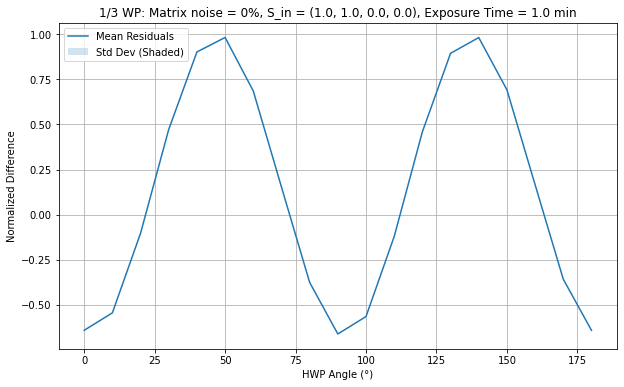

In [6]:
# For collecting single differences
normalized_diffs_list = []

# NOTE: For QWP
delta_HWP = 0.3661
filename_tag = "Third_WP"

# Loop over each target
for target in targets:
    mean_residuals = []
    std_residuals = []

    # Loop over matrix noise levels
    for matrix_noise in matrix_noise_range:
        residuals = []

        # Perform multiple trials for each noise level
        for trial in range(num_trials):
            normalized_diff = instrument_mm.calculate_input_Q_U_observing_sequence_matrix_inversion(
                ra=target["ra"], 
                dec=target["dec"], 
                observer_latitude=observer_latitude, 
                observer_longitude=observer_longitude, 
                jd_str=observation_date, 
                ut_start=observation_time, 
                t_int=t_int, 
                Q=Q_injected, 
                U=U_injected, 
                V=V_injected,
                delta_HWP=delta_HWP,
                HWP_angs = HWP_angs,
                noise_percentage=noise_percentage,
                include_V=include_V,
                sub_tint=sub_tint,  # Sub-integration time in seconds
                TMT_matrix_noise=matrix_noise,
                NFIRAOS_matrix_noise=matrix_noise,
                MODHIS_matrix_noise=matrix_noise,
                observable="intensities",  # Or "single_difference" if needed
                sampled_steps = num_samples,
                matrix_noise_type = matrix_noise_type,
                return_type = "normalized_diff"
            )
            normalized_diffs_list.append(normalized_diff)

        # Compute mean and standard deviation of residuals for this noise level
        normalized_diffs_list = np.array(normalized_diffs_list)
        normalized_diffs_medians = np.median(normalized_diffs_list, axis = 0)
        normalized_diffs_stds = np.std(normalized_diffs_list, axis = 0)

        # Save the residuals as a .npy file
        filename = f"{target['name']}_QWP_Q_{Q_injected}_U_{U_injected}_V_{V_injected}_residuals_matrix_noise_{matrix_noise}_tint_{t_int}_sub_tint_{sub_tint}_readout_noise_{noise_percentage}_{matrix_noise_type}_{filename_tag}.npy"
        np.save(filename, np.array(normalized_diffs_list))
        print(f"Saved residuals to {filename}")

    # Plot the NOrmalized difference 
    plt.figure(figsize=(10, 6))

    plt.plot(HWP_angs, normalized_diffs_medians, label=f"Mean Residuals")
    plt.fill_between(HWP_angs, normalized_diffs_medians - normalized_diffs_stds, normalized_diffs_medians + normalized_diffs_stds, alpha=0.2, label="Std Dev (Shaded)")
    plt.xlabel("HWP Angle (°)")
    plt.ylabel("Normalized Difference")
    plt.title(
        f"1/3 WP: Matrix noise = {matrix_noise}%, S_in = (1.0, {Q_injected}, {U_injected}, {V_injected}), Exposure Time = {t_int / 60:.1f} min"
    )
    plt.grid(True)
    plt.legend()
    plt.show()
